# Probabilistic K-nearest Neighbours (PKNN)

In [1]:
import jax
import chex
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

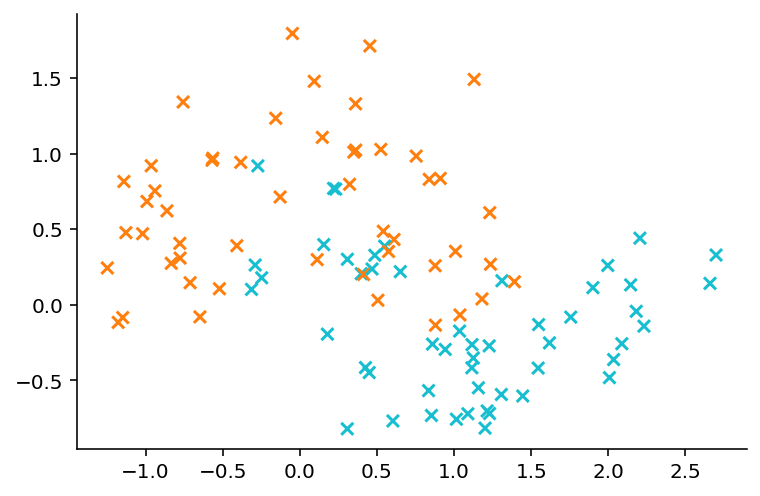

In [3]:
noise = 0.3
X, y = make_moons(101, noise=noise, random_state=314)
colors = ["tab:cyan" if yi else "tab:orange" for yi in y]
plt.scatter(*X.T, c=colors, marker="x")

## Plain-vanilla K-nearest neighbours

In [4]:
def knn(x, X, Y, k):
    """
    Classify an input x based on
    its k closest nearest neighbours
    
    Parameters
    ----------
    x: jnp.array(M,)
        Test observation
    X: jnp.array(N, M)
        Train features
    y: jnp.array(N,)
        Train covariates
    """
    N, _ = X.shape
    mask = jnp.arange(N) < k
    
    distances = jnp.linalg.norm(x - X, axis=1)
    nearest = jnp.argsort(distances)
    
    Y_pred = jnp.take(Y, nearest) * mask
    return Y_pred.sum() / k 

In [5]:
k = 3
knn_vmap = jax.vmap(knn, (1, None, None, None), out_axes=0)
knn_vmap = jax.vmap(knn_vmap, (2, None, None, None), out_axes=1)
knn_vmap_k = jax.vmap(knn_vmap, (None, None, None, 0), out_axes=0)

In [6]:
# steps = 50j
steps = 0.009
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
grid = jnp.mgrid[xmin:xmax:steps, ymin:ymax:steps]
k_values = jnp.array([1, 3, 6, 12])

k_distances_grid = knn_vmap_k(grid, X, y, k_values)

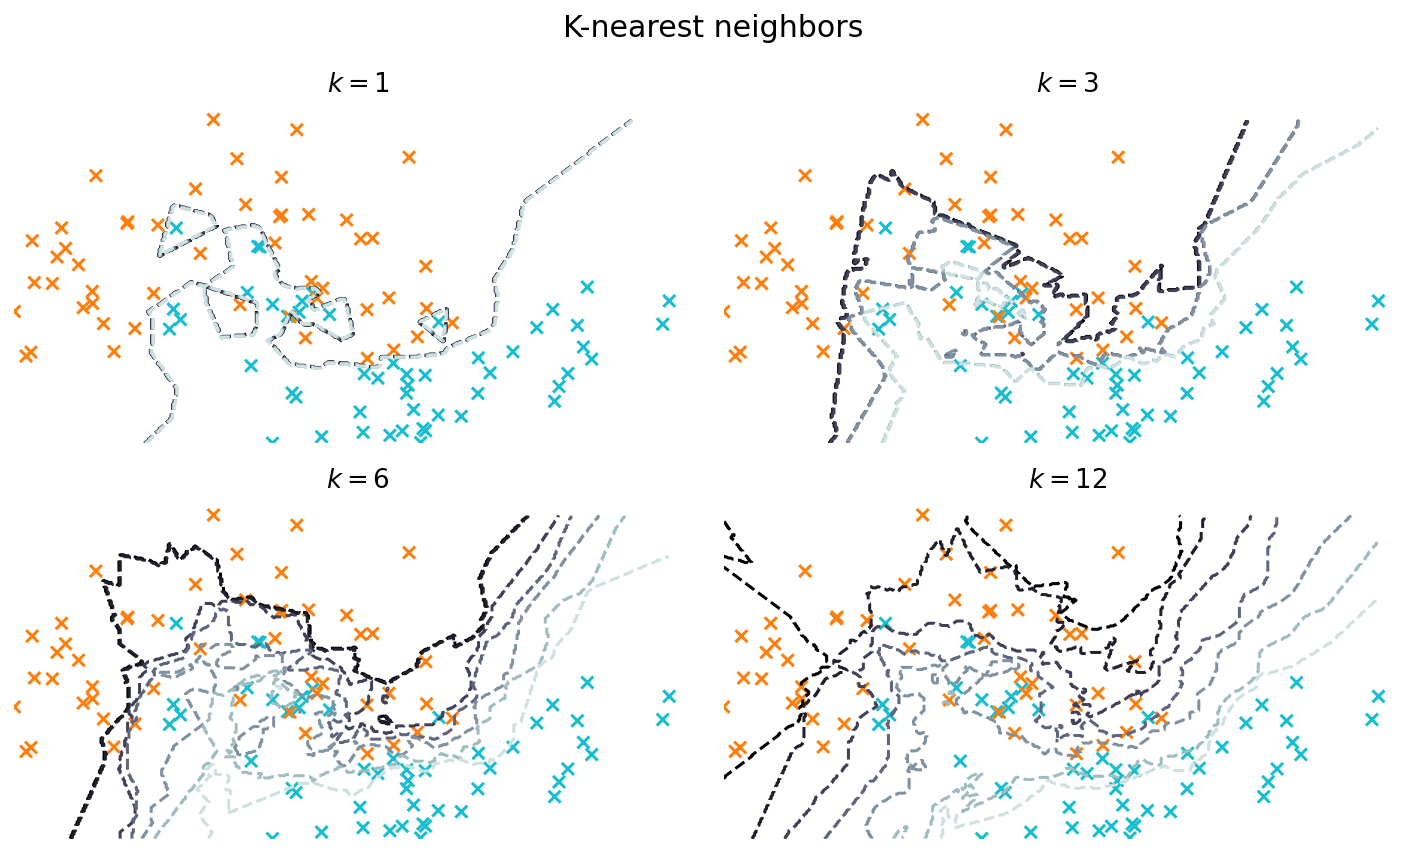

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for axi, k, dgrid in zip(ax, k_values, k_distances_grid):    
    axi.axis("off")
    axi.contour(*grid, dgrid, cmap="bone", linestyles="--")
    axi.set_title(f"$k={k}$", fontsize=13)
    axi.scatter(*X.T, c=colors, marker="x")
plt.suptitle("K-nearest neighbors", fontsize=15)
plt.tight_layout()

## Probabilistic KNN

$$
p(y_i \vert {\bf x}, \beta, k) = \frac{\exp\left(\frac{\beta}{k}\sum_{n\vert {\bf x}_n \in \mathcal{N}({\bf x}_i)}\mathbb{1}(y_n = y_i)\right)}{\sum_{q=1}^Q\exp\left(\frac{\beta}{k}\sum_{n\vert {\bf x}_n \in \mathcal{N}({\bf x}_i)}\mathbb{1}(y_n = q)\right)}
$$

In [8]:
def knn_term(x, y, X, Y, k, beta):
    N, _ = X.shape
    mask = jnp.arange(N)
    mask = (mask <= k) * (mask > 0)
    
    distances = jnp.linalg.norm(x - X, axis=1) ** 2
    nearest = jnp.argsort(distances)
    
    Y_pred = (jnp.take(Y, nearest) == y) * mask
    dist = beta / k * Y_pred.sum()
    return jnp.exp(dist)

knn_term_vmap = jax.vmap(knn_term, (0, 0, None, None, None, None))
knn_term_classes_vmap = jax.vmap(knn_term, (0, None, None, None, None, None))
knn_term_classes_vmap = jax.vmap(knn_term_classes_vmap, (None, 0, None, None, None, None))

In [9]:
k = 6
beta = 0.1
Q = 2
noise = 0.3
classes = jnp.array([0, 1])

In [10]:
X_cv, y_cv = make_moons(20, noise=noise, random_state=271)

x_test = jnp.array([0, 0.5])

In [11]:
unnorm_prob = knn_term_classes_vmap(X_cv, classes, X_cv, y_cv, k, beta)

N, _ = X_cv.shape
normalisation = unnorm_prob.sum(axis=0)
unnorm_prob = unnorm_prob[y_cv, jnp.arange(N)]

likelihood = unnorm_prob / normalisation
likelihood

DeviceArray([0.5083321 , 0.51665986, 0.5083321 , 0.5083321 , 0.51665986,
             0.51665986, 0.4916679 , 0.48334005, 0.51665986, 0.5083321 ,
             0.51665986, 0.5083321 , 0.5083321 , 0.5083321 , 0.5083321 ,
             0.5083321 , 0.4916679 , 0.4916679 , 0.5083321 , 0.5       ],            dtype=float32)

In [12]:
def compute_likelihood(X, y, k, beta):
    N, _ = X.shape
    unnorm_prob = knn_term_classes_vmap(X, classes, X, y, k, beta)
    
    normalisation = unnorm_prob.sum(axis=0)
    unnorm_prob = unnorm_prob[y, jnp.arange(N)]

    likelihood = unnorm_prob / normalisation

    
    return jnp.prod(likelihood)

In [13]:
compute_likelihood(X_cv, y_cv, k, beta)

DeviceArray(1.2182519e-06, dtype=float32)

## Sampling

In [493]:
jnp.array([jnp.inf]) / jnp.inf

DeviceArray([nan], dtype=float32)

In [506]:
k_vals = jnp.arange(-4, 5)

def knn_mcmc_step(key, state, X, y, eta):
    N, _ = X.shape
    k, beta, count_acc = state
    
    key_beta, key_k, key_accept = jax.random.split(key, 3)
    
    delta_beta = jax.random.normal(key_beta)
    delta_k = jax.random.choice(key_k, k_vals)
    
    k_hat = jnp.clip(k + delta_k, 1, N)
    beta_hat = jnp.abs(beta + delta_beta * eta)
    
    L_hat = compute_likelihood(X, y, k_hat, beta_hat)
    L = compute_likelihood(X, y, k, beta)
    
    A = jnp.minimum(1, L_hat / L)
    acc = jax.random.bernoulli(key_accept, p=A)
    k, beta, acc = jax.lax.cond(acc, lambda: (k_hat, beta_hat, 1),
                                     lambda: (k, beta, 0))
    
    count_acc = count_acc + acc
    res = {
        "k": k,
        "beta": beta,
    }
    return (k, beta, count_acc), res

def knn_mcmc(key_init, k_init, beta_init, X, y, eta, num_steps, num_warmup):
    num_steps = num_warmup + num_steps
    keys_steps = jax.random.split(key_init, num_steps)
    
    knnmcmc_part = partial(knn_mcmc_step, X=X, y=y, eta=eta)
    init_state = (k_init, beta_init, 0)
    (_, _, n_acc), chain = jax.lax.scan(lambda s, k: knnmcmc_part(k, s), init_state, keys_steps)
    
    chain["prop_accepted"] = n_acc / num_steps
    return chain

In [ ]:
num_warmup = 1_000
num_steps = 3_000
eta = 1.5
key = jax.random.PRNGKey(3141)
keys = jax.random.split(key, 3)

k_init = jnp.array([1, 30, 2.0])
beta_init = jnp.array([10, 0.01, 2.0])

knn_mcmc_vmap = jax.vmap(knn_mcmc, in_axes=(0, 0, 0, None, None, None, None, None))
chains = knn_mcmc_vmap(keys, k_init, beta_init, X, y, eta, num_steps, num_warmup)

chains["prop_accepted"]

In [17]:
chains["k"][:, num_warmup:].mean(axis=1)

DeviceArray([17.954   , 18.727   , 18.309334], dtype=float32)

In [18]:
chains["beta"][:, num_warmup:].mean(axis=1)

DeviceArray([4.259292, 4.263984, 4.269792], dtype=float32)

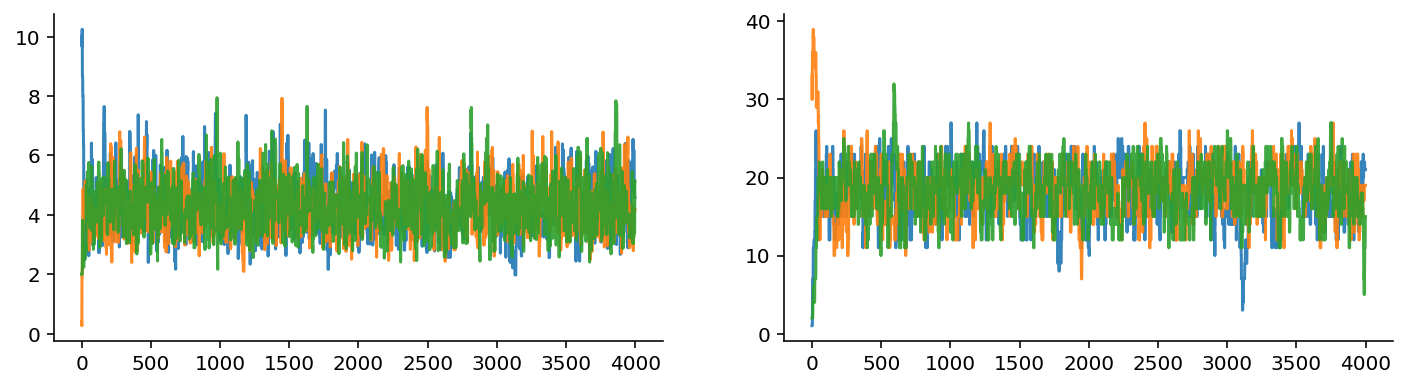

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(chains["beta"].T, alpha=0.9);
ax[1].plot(chains["k"].T, alpha=0.9);

In [20]:
chains_beta = chains["beta"][:, num_warmup:]
chains_k = chains["k"][:, num_warmup:].astype(int)

<AxesSubplot:ylabel='Count'>

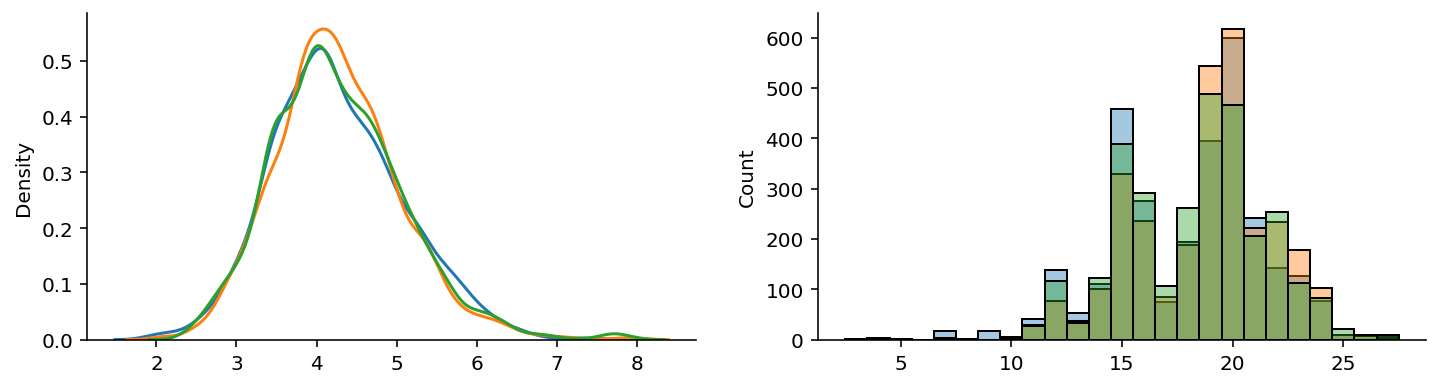

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

sns.kdeplot(chains_beta[0], ax=ax[0])
sns.kdeplot(chains_beta[1], ax=ax[0])
sns.kdeplot(chains_beta[2], ax=ax[0])


sns.histplot(chains_k[0], ax=ax[1], discrete=True, color="tab:blue", alpha=0.4)
sns.histplot(chains_k[1], ax=ax[1], discrete=True, color="tab:orange", alpha=0.4)
sns.histplot(chains_k[2], ax=ax[1], discrete=True, color="tab:green", alpha=0.4)

### The predictive distribution

$$
    p(y_{n+1}\vert {\bf x}_{n+1}, Y, X) \approx \frac{1}{I}\sum_{i=1}^Ip(y_{n + 1}\vert Y, X, \beta^{(i)}, k^{(i)})
$$

In [22]:
def knnexp(x, y, X, Y, k, beta):
    N, _ = X.shape
    mask = jnp.arange(N) < k
    
    distances = jnp.linalg.norm(x - X, axis=1)
    nearest = jnp.argsort(distances)
    
    Y_pred = (jnp.take(Y, nearest) == y) * mask
    dist = beta / k * Y_pred.sum()
    dist = jnp.clip(dist, -30, 30)
    return jnp.exp(dist)

knnexp_vmap = jax.vmap(knnexp, (None, 0, None, None, None, None))


def knn_prob(x, y, X, Y, k, beta):
    unnorm_prob = knnexp_vmap(x, classes, X, Y, k, beta)
    normalisation = unnorm_prob.sum()
    unnorm_prob = unnorm_prob[y]

    prob = unnorm_prob / normalisation
    return prob

knn_prob_posterior = jax.vmap(knn_prob, (None, None, None, None, 0, 0))

In [23]:
knn_prob_posterior_grid = jax.vmap(knn_prob_posterior, (1, None, None, None, None, None), out_axes=0)
knn_prob_posterior_grid = jax.vmap(knn_prob_posterior_grid, (2, None, None, None, None, None), out_axes=1)

In [24]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
step = 0.05
grid = jnp.mgrid[xmin - 0.1:xmax * 1.1:step, ymin - 0.1:ymax * 1.1:step]

In [25]:
k_probs_posterior_grid = knn_prob_posterior_grid(grid, 1, X, y, chains_beta[0], chains_k[0])
k_probs_posterior_mean = k_probs_posterior_grid.mean(axis=-1)
k_probs_posterior_std = k_probs_posterior_grid.std(axis=-1)

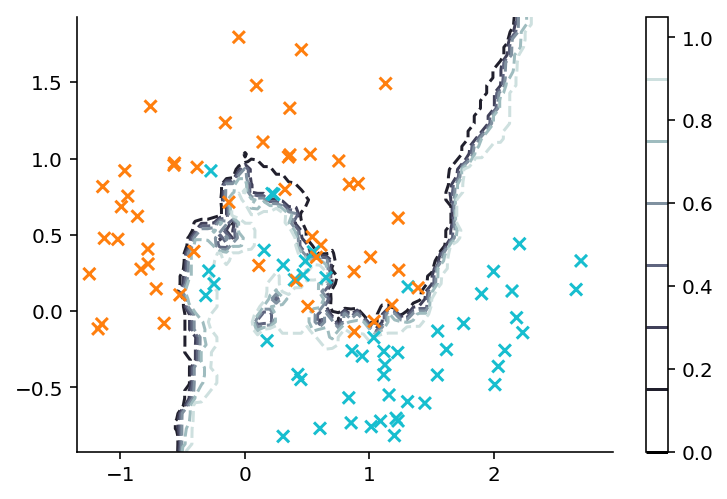

In [26]:
colors = ["tab:cyan" if yi else "tab:orange" for yi in y]
plt.scatter(*X.T, c=colors, marker="x")
plt.contour(*grid, k_probs_posterior_mean, cmap="bone", linestyles="--", zorder=0)
plt.colorbar(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1]);

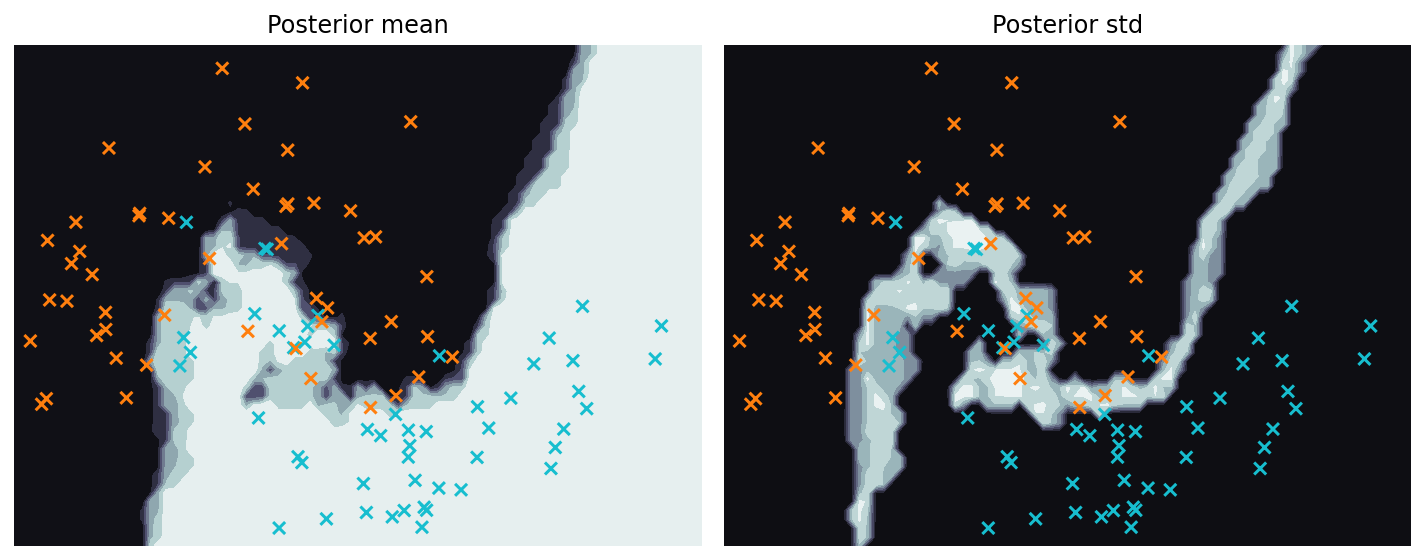

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
colors = ["tab:cyan" if yi else "tab:orange" for yi in y]


ax[0].scatter(*X.T, c=colors, marker="x")
ax[0].contourf(*grid, k_probs_posterior_mean, cmap="bone", linestyles="--", zorder=0)
ax[0].set_title("Posterior mean")
ax[0].axis("off");

ax[1].set_title("Posterior std")
ax[1].scatter(*X.T, c=colors, marker="x")
ax[1].contourf(*grid, k_probs_posterior_std, cmap="bone", linestyles="--", zorder=0)
ax[1].axis("off");

plt.tight_layout()

# KNN v.s PKNN

## Moon's dataset

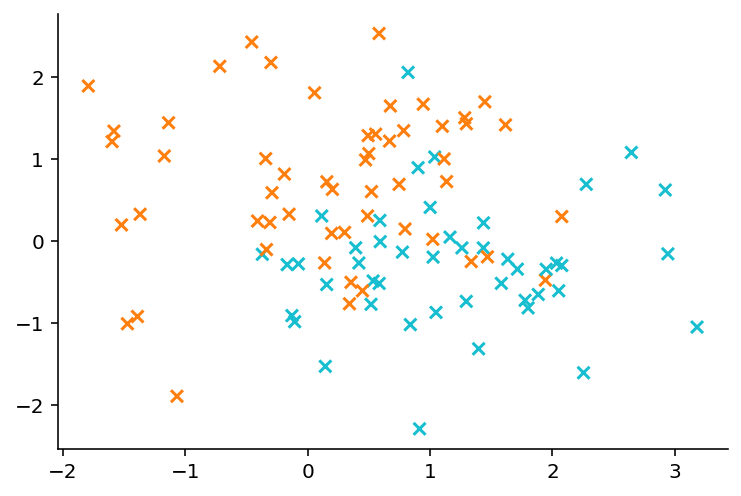

In [28]:
noise = 0.7
n_train = 100
n_test = 100
X, y = make_moons(n_train + n_test, noise=noise, random_state=314)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

colors = ["tab:cyan" if yi else "tab:orange" for yi in y_train]
plt.scatter(*X_train.T, c=colors, marker="x")

### KNN

In [29]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

In [30]:
%%time
k_neighs = np.arange(1, 80)
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors": k_neighs}, pre_dispatch=90)
res = knn_gs.fit(X_train, y_train)

CPU times: user 737 ms, sys: 1 ms, total: 738 ms
Wall time: 735 ms


In [31]:
res.best_estimator_, res.best_score_

(KNeighborsClassifier(n_neighbors=15), 0.8)

### PKNN

In [32]:
%%time
num_warmup = 100_000
num_steps = 20_000
eta = 0.9
key = jax.random.PRNGKey(3141)
keys = jax.random.split(key, 2)

k_init = jnp.array([10, 40])
beta_init = jnp.array([1.0, 0.01])

chains = knn_mcmc_vmap(keys, k_init, beta_init, X_train, y_train, eta, num_steps, num_warmup)

chains["prop_accepted"].block_until_ready()

CPU times: user 3.1 s, sys: 44.6 ms, total: 3.15 s
Wall time: 37.6 s


DeviceArray([0.620875 , 0.6250917], dtype=float32)

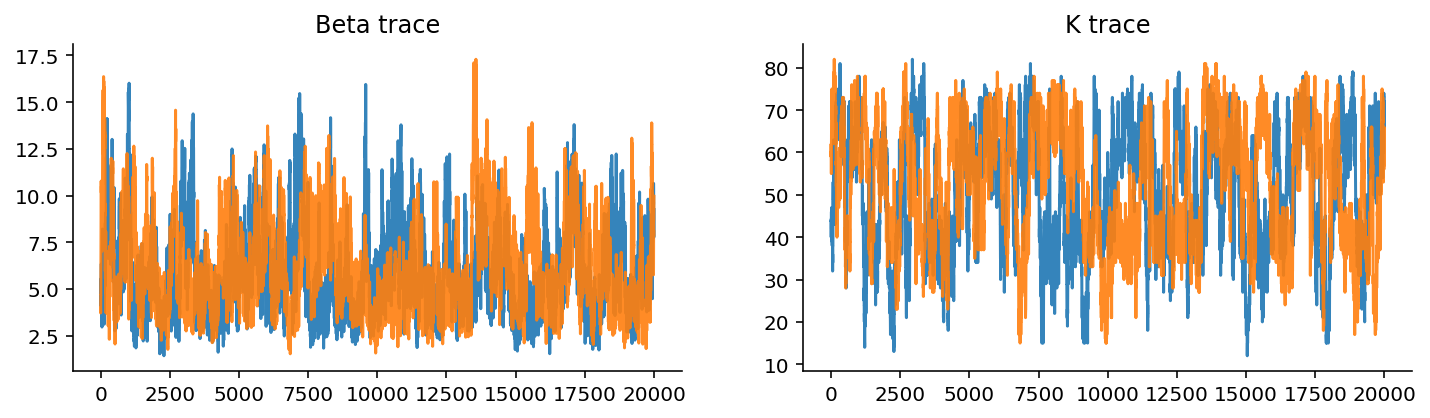

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(chains["beta"].T[num_warmup:], alpha=0.9);
ax[1].plot(chains["k"].T[num_warmup:], alpha=0.9);

ax[0].set_title("Beta trace")
ax[1].set_title("K trace");

In [34]:
chains_beta = chains["beta"][:, num_warmup:]
chains_k = chains["k"][:, num_warmup:].astype(int)

<AxesSubplot:ylabel='Count'>

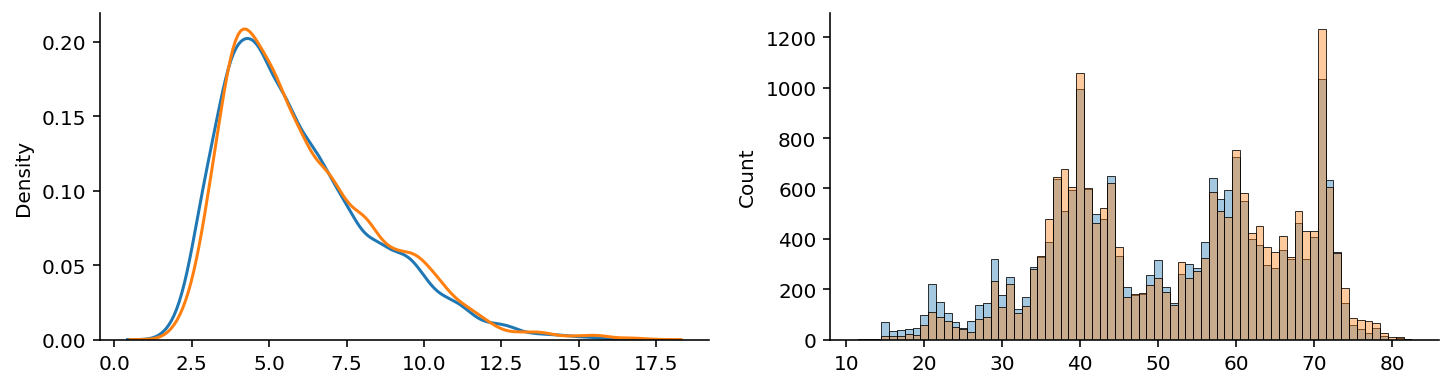

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

sns.kdeplot(chains_beta[0], ax=ax[0])
sns.kdeplot(chains_beta[1], ax=ax[0])


sns.histplot(chains_k[0], ax=ax[1], discrete=True, color="tab:blue", alpha=0.4)
sns.histplot(chains_k[1], ax=ax[1], discrete=True, color="tab:orange", alpha=0.4)

In [36]:
knn_prob_posterior_vmap = jax.vmap(knn_prob_posterior, (0, None, None, None, None, None), out_axes=0)
probs = knn_prob_posterior_vmap(X_test, 1, X_train, y_train, chains_k[1], chains_beta[1])

## Base prediction

In [37]:
yhat_pknn = (probs.mean(axis=1) > 0.5).astype(int)
yhat_knn = knn_gs.predict(X_train)

In [38]:
f1_score(y_test, yhat_knn)

0.5294117647058824

In [39]:
f1_score(y_test, yhat_pknn)

0.6896551724137931

In [40]:
confusion_matrix(y_test, yhat_pknn)

array([[43,  3],
       [24, 30]])

In [41]:
confusion_matrix(y_test, yhat_knn)

array([[25, 21],
       [27, 27]])

## Comparing prediction uncertainty

In [42]:
knn_probs = knn_gs.predict_proba(X_test)
pknn_probs = probs.mean(axis=1)

### Class 1 test

In [43]:
jnp.take(y_test, jnp.where(knn_probs > 0.7)[0]).mean()

DeviceArray(0.46153846, dtype=float32)

In [44]:
jnp.take(y_test, jnp.where(pknn_probs > 0.7)[0]).mean()

DeviceArray(0.9166667, dtype=float32)

### Class 2 test

In [45]:
1 - jnp.take(y_test, jnp.where(knn_probs < 0.3)[0]).mean()

DeviceArray(0.53846157, dtype=float32)

In [46]:
1 - jnp.take(y_test, jnp.where(pknn_probs < 0.3)[0]).mean()

DeviceArray(0.7708333, dtype=float32)

## Orstein-Uhlenbeck (OU) processs

An OU process is given by

$$
    dS_t = \kappa(\bar S - S_t) + \sigma dW_t
$$

Where
* $\kappa$ is the force of the mean-reverting effect
* $\bar S$ is the mean-reverting value
* $\sigma$ is the stardard deviation of the process


In [51]:
@chex.dataclass
class OUParams:
    kappa: float
    mean: float
    sigma: float

In [109]:
def ou_step(s_prev, key, dt, params):
    noise = jax.random.normal(key)
    s_next = s_prev + params.kappa * (params.mean - s_prev) * dt + jnp.sqrt(dt) * params.sigma * noise
    return s_next, s_next

def simulate_ou(key, s_init, params, T, dt):
    time = jnp.arange(0, T, dt)
    n_steps = len(time)
    keys = jax.random.split(key, n_steps)
    part_ou = partial(ou_step, dt=dt, params=params)
    
    _, simulation = jax.lax.scan(part_ou, s_init, keys)
    return simulation, time

In [235]:
mean = 10.0
params = OUParams(kappa=1.0, mean=mean, sigma=0.1)

In [222]:
key = jax.random.PRNGKey(314)
dt = 0.005
T = 5

n_sims = 8
keys = jax.random.split(key, n_sims)

simulate_ou_pmap = partial(simulate_ou, s_init=10.0, params=params, T=T, dt=dt)
simulate_ou_pmap = jax.pmap(simulate_ou_pmap, in_axes=0)
simulations, time = simulate_ou_pmap(keys)
time = time[0]

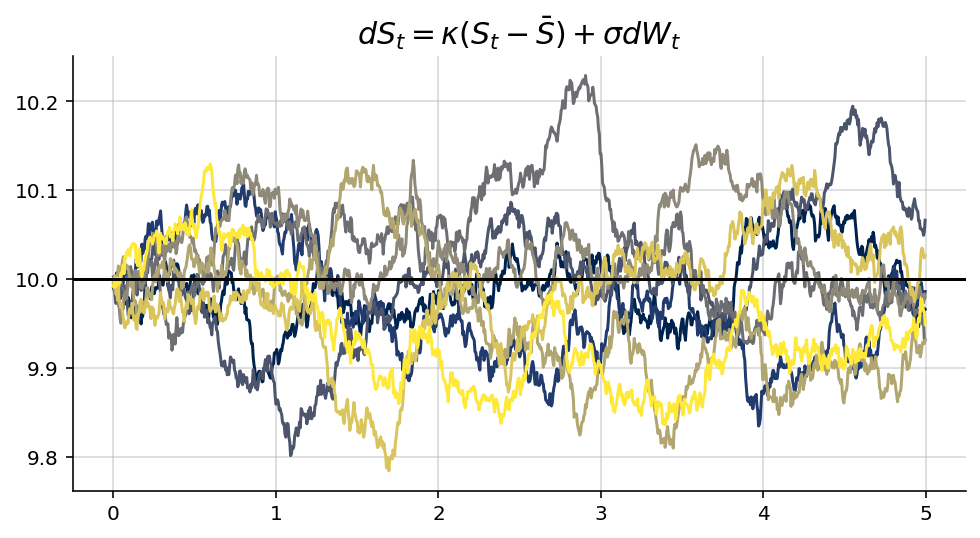

In [223]:
colors = plt.cm.cividis(jnp.linspace(0, 1, n_sims))

fig, ax = plt.subplots(figsize=(8, 4))

for n, simulation in enumerate(simulations):
    plt.plot(time, simulation, c=colors[n])

plt.title(r"$dS_t = \kappa (S_t - \bar S) + \sigma dW_t$", fontsize=15)
plt.axhline(params.mean, c="black")
plt.grid(alpha=0.5)

### Generating training data

In [224]:
import pandas as pd
import numpy as np

def ts_supervised(data, n_in=1, n_out=1):
    """
    Transform a matrix of size TxS to a supervised machine learning
    problem.
    
    n_in: int
        The number of previous steps to consider. This is the
        X matrix of values (x_{t-n_in}, ..., x_{t-1}) as input 
        to the model
        
    n_out: int
        The number of posterior steps to consider. This is a 
        Y matrix of values (y_{t}, y_{t+1}, ..., y_{t+n_out})
        which serves as output to the model
    """
    _, n_vars = data.shape
    base_cols = data.columns
    cols, col_names = [], []
    agg = {}
    # Input sequence (t-n, .., t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        col_names.extend([f"{base_cols[j-1]}(t-{i})"
                          for j in range(1, n_vars + 1)])
    # forecast sequence (t, .., t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        col_names.extend([f"{base_cols[j-1]}(t+{i})".replace("+0", "")
                           for j in range(1, n_vars + 1)])

    agg = pd.concat(cols, axis=1).dropna()
    agg.columns = col_names
    return agg


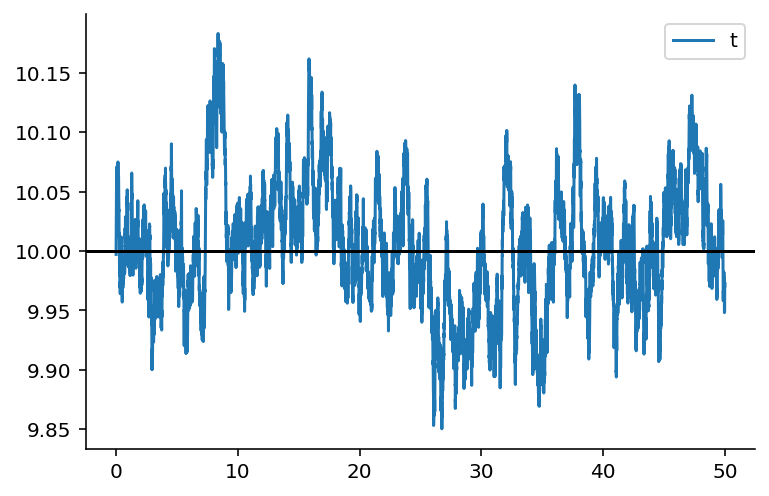

In [239]:
simulation.plot()
plt.axhline(y=mean, c="black")

In [476]:
dt = 0.005
T = 100
simulation, time = simulate_ou(key, 10.0, params, T, dt)
simulation = pd.DataFrame(simulation.to_py(), index=time, columns=["S"])

t_fwd = 50
S = ts_supervised(simulation, 20, t_fwd).iloc[::t_fwd]
S = S.sample(frac=1.0, replace=False)

n_test = 50

In [524]:
y = (S.iloc[:, -1] > mean).values.astype(int)
y = jnp.array(y).astype(int)

In [525]:
X = S.iloc[:, :-t_fwd].values
X = jnp.array(X)

(399, 20)

In [526]:
y_test = y[-n_test:]
X_test = X[-n_test:]

X = X[:-n_test]
y = y[:-n_test]

In [481]:
%%time
k_neighs = np.arange(1, 50)
knn_gs = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors": k_neighs}, pre_dispatch=90)
knn_gs.fit(X, y)
knn_gs.best_estimator_, knn_gs.best_score_

CPU times: user 2min 57s, sys: 4.38 s, total: 3min 1s
Wall time: 3.84 s


(KNeighborsClassifier(n_neighbors=12), 0.8080745341614908)

In [639]:
k_vals = jnp.arange(-4, 5)
k_vals = jnp.arange(-10, 11, 3)

def compute_log_likelihood(X, y, k, beta):
    N, _ = X.shape
    unnorm_prob = knn_term_classes_vmap(X, classes, X, y, k, beta)
    
    normalisation = unnorm_prob.sum(axis=0)
    unnorm_prob = unnorm_prob[y, jnp.arange(N)]

    log_likelihood = jnp.log(unnorm_prob) - jnp.log(normalisation)

    
    return jnp.sum(log_likelihood)

def knn_mcmc_step(key, state, X, y, eta):
    N, _ = X.shape
    k, beta, count_acc = state
    
    key_beta, key_k, key_accept = jax.random.split(key, 3)
    
    delta_beta = jax.random.normal(key_beta)
    delta_k = jax.random.choice(key_k, k_vals)
    
    k_hat = jnp.clip(k + delta_k, 1, 100)
    beta_hat = jnp.abs(beta + delta_beta * eta)
    
    logL_hat = compute_log_likelihood(X, y, k_hat, beta_hat)
    logL = compute_log_likelihood(X, y, k, beta)
    
    A = jnp.minimum(1, jnp.exp(logL_hat - logL))
    acc = jax.random.bernoulli(key_accept, p=A)
    k, beta, acc = jax.lax.cond(acc, lambda: (k_hat, beta_hat, 1),
                                     lambda: (k, beta, 0))
    
    count_acc = count_acc + acc
    res = {
        "k": k,
        "beta": beta,
        "A": A
    }
    return (k, beta, count_acc), res

def knn_mcmc(key_init, k_init, beta_init, X, y, eta, num_steps, num_warmup):
    num_steps = num_warmup + num_steps
    keys_steps = jax.random.split(key_init, num_steps)
    
    knnmcmc_part = partial(knn_mcmc_step, X=X, y=y, eta=eta)
    init_state = (k_init, beta_init, 0)
    (_, _, n_acc), chain = jax.lax.scan(lambda s, k: knnmcmc_part(k, s), init_state, keys_steps)
    
    chain["prop_accepted"] = n_acc / num_steps
    return chain

In [640]:
%%time
num_warmup = 10_000
num_steps = 3_000
eta = 1.3
key = jax.random.PRNGKey(3141)
keys = jax.random.split(key, 2)

k_init = jnp.array([2, 50])
beta_init = jnp.array([1.0, 0.01])


knn_mcmc_pmap = partial(knn_mcmc, X=X, y=y, eta=eta, num_steps=num_steps, num_warmup=num_warmup)
knn_mcmc_pmap = jax.vmap(knn_mcmc_pmap, in_axes=(0, 0, 0))

chains = knn_mcmc_pmap(keys, k_init, beta_init)
# chains = knn_mcmc_vmap(keys, k_init, beta_init, X, y, eta, num_steps, num_warmup)

chains["prop_accepted"].block_until_ready()

CPU times: user 3.88 s, sys: 23.5 ms, total: 3.91 s
Wall time: 43.6 s


DeviceArray([0.17915384, 0.18599999], dtype=float32)

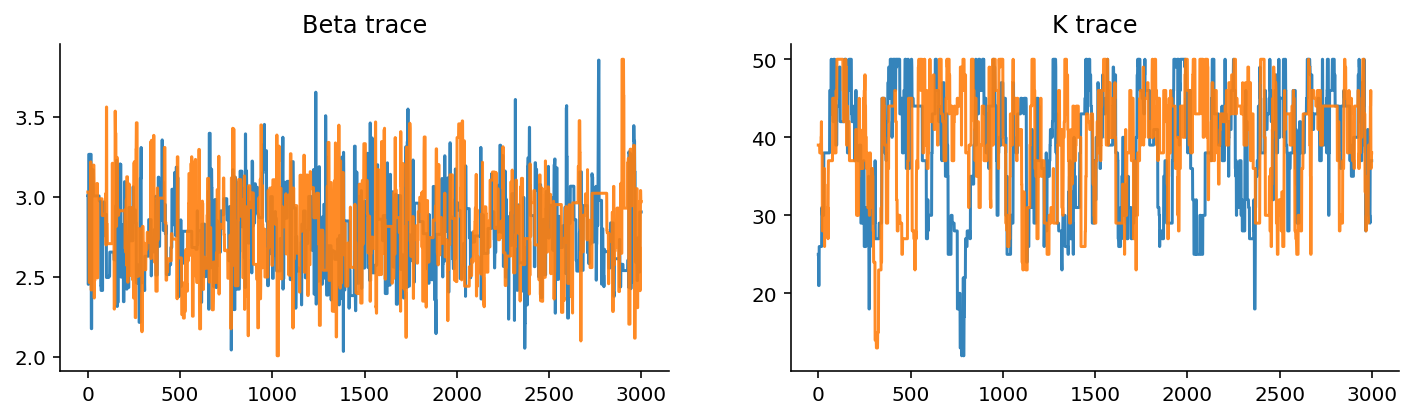

In [641]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(chains["beta"].T[num_warmup:], alpha=0.9);
ax[1].plot(chains["k"].T[num_warmup:], alpha=0.9);

ax[0].set_title("Beta trace")
ax[1].set_title("K trace");

In [642]:
chains_beta = chains["beta"][:, num_warmup:]
chains_k = chains["k"][:, num_warmup:].astype(int)

<AxesSubplot:ylabel='Count'>

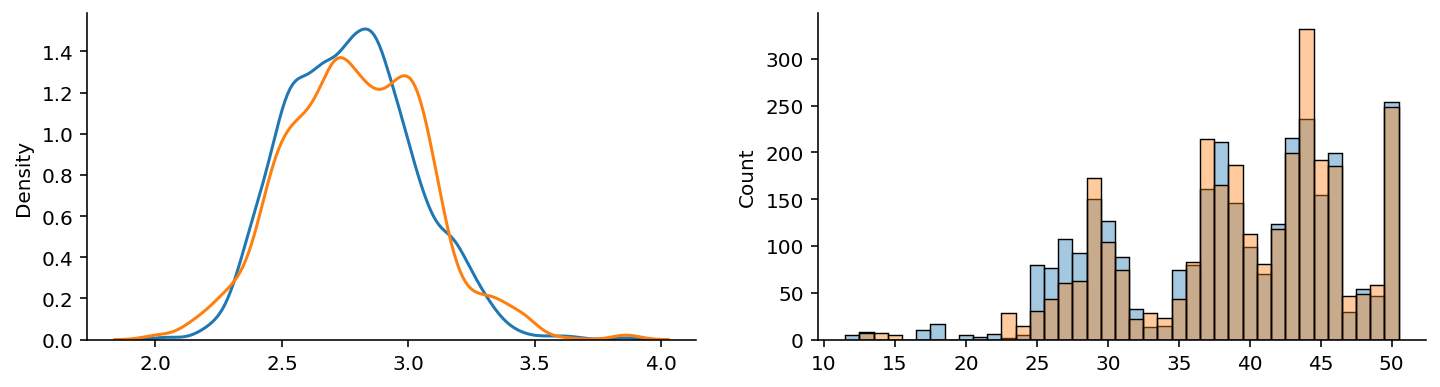

In [644]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

sns.kdeplot(chains_beta[0], ax=ax[0])
sns.kdeplot(chains_beta[1], ax=ax[0])


sns.histplot(chains_k[0], ax=ax[1], discrete=True, color="tab:blue", alpha=0.4)
sns.histplot(chains_k[1], ax=ax[1], discrete=True, color="tab:orange", alpha=0.4)

In [656]:
knn_prob_posterior_vmap = jax.vmap(knn_prob_posterior, (0, None, None, None, None, None), out_axes=0)
probs = knn_prob_posterior_vmap(X_test, 1, X, y, chains_k[0], chains_beta[0])

## Base prediction

In [657]:
yhat_pknn = (probs.mean(axis=1) > 0.5).astype(int)
yhat_knn = knn_gs.predict(X_test)

In [658]:
f1_score(y_test, yhat_knn)

0.8076923076923077

In [659]:
f1_score(y_test, yhat_pknn)

0.830188679245283

In [660]:
confusion_matrix(y_test, yhat_pknn)

array([[19,  4],
       [ 5, 22]])

In [661]:
confusion_matrix(y_test, yhat_knn)

array([[19,  4],
       [ 6, 21]])

## Comparing prediction uncertainty

In [662]:
knn_probs = knn_gs.predict_proba(X_test)
pknn_probs = probs.mean(axis=1)

### Class 1 test

In [663]:
jnp.take(y_test, jnp.where(knn_probs > 0.7)[0]).mean()

DeviceArray(0.6, dtype=float32)

In [664]:
jnp.take(y_test, jnp.where(pknn_probs > 0.7)[0]).mean()

DeviceArray(0.8636364, dtype=float32)

### Class 2 test

In [665]:
1 - jnp.take(y_test, jnp.where(knn_probs < 0.3)[0]).mean()

DeviceArray(0.39999998, dtype=float32)

In [666]:
1 - jnp.take(y_test, jnp.where(pknn_probs < 0.3)[0]).mean()

DeviceArray(0.7777778, dtype=float32)